# Visual Question Answering using Multimodal Transformer Models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
import os
os.chdir('/content/drive/MyDrive/USC_Course/Multimodal_Probabilistic_Learning_of_Human_CSCI535/Group_Project/VQA-With-Multimodal-Transformers-main')

In [5]:
!pip install datasets

## Import necessary libraries & set up the environment

In [6]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_caching_enabled(True)
logging.set_verbosity_error()

<ipython-input-7-705839fc65d9>:6: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.
  set_caching_enabled(True)


In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cuda:0
Tesla T4


In [9]:
dataset = load_dataset(
    "csv",
    data_files={
        # "train": os.path.join("..", "dataset", "data_train.csv"),
        "train": os.path.join("Our_dataset", "data_train.csv"),
        # "test": os.path.join("..", "dataset", "data_eval.csv")
        "test": os.path.join("Our_dataset", "data_eval.csv")
    }
)

# with open(os.path.join("..", "dataset", "answer_space.txt")) as f:
with open(os.path.join("Our_dataset", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()
    # print(answer_space)

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 1497
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 686
    })
})

In [10]:
print(dataset.keys())

dict_keys(['train', 'test'])


### Look at some of the Question/Image/Answer combinations

In [11]:
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    # print(data[id])
    # image = Image.open(os.path.join("..", "dataset", "images", data[id]["image_id"] + ".png"))
    image = Image.open(os.path.join("Our_dataset", "images", data[id]["image_id"] + ".jpg"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

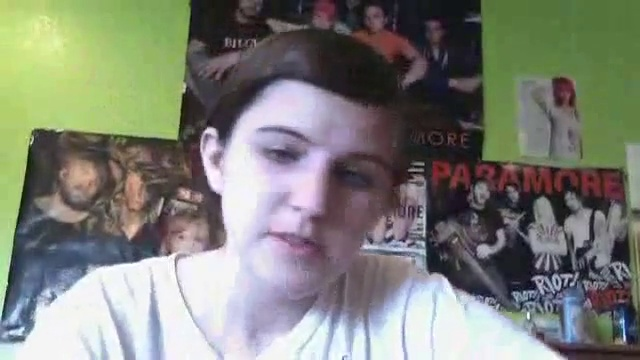

Question:	 What is the emotion in the image OtBXNcAL_lE_19?
Answer:		 sad (Label: 1)


In [12]:
showExample()

### Create a Multimodal Collator for the Dataset

This will be used in the `Trainer()` to automatically create the `Dataloader` from the dataset to pass inputs to the model

The collator will process the **question (text)** & the **image**, and return the **tokenized text (with attention masks)** along with the **featurized image** (basically, the **pixel values**). These will be fed into our multimodal transformer model for question answering.

In [13]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("Our_dataset", "images", image_id + ".jpg")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }

    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

In [14]:
class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'bert-base-uncased',
            pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):

        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()

    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):

        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)

        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out

In [15]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )


    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

## Performance Metrics from Visual Question Answering

In [16]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a)
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score

In [17]:
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [18]:
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['happy', 'happy', 'happy', 'sad', 'happy']
['normal', 'happy', 'normal', 'sad', 'sad']
Predictions vs Labels:  0.4
Labels vs Labels:  1.0


In [19]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

## Model Training & Evaluation

### Define the Arguments needed for Training

In [19]:
!pip install transformers[torch] -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 35.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux

In [19]:
!pip install accelerate==0.27.2

  Using cached accelerate-0.27.2-py3-none-any.whl (279 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.29.3
    Uninstalling accelerate-0.29.3:
      Successfully uninstalled accelerate-0.29.3


In [25]:
args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,             # Save only the last 3 checkpoints at any given time while training
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    save_safetensors = False,
    num_train_epochs=1,
    fp16=True,
    # warmup_ratio=0.01,
    # learning_rate=5e-4,
    # weight_decay=1e-4,
    # gradient_accumulation_steps=2,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
)

### Create the Multimodal Models using User-Defined Text/Image  Transformers & Train it on the Dataset

In [26]:
def createAndTrainModel(dataset, args, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224-in21k', multimodal_model='bert_vit'):
    collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)

    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("checkpoint", multimodal_model)
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )

    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()

    return collator, model, train_multi_metrics, eval_multi_metrics

In [27]:
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing

{'train_runtime': 55.7868, 'train_samples_per_second': 26.834, 'train_steps_per_second': 0.842, 'train_loss': 1.0717788046978889, 'epoch': 1.0}
{'eval_loss': 1.144284963607788, 'eval_wups': 0.2536443148688047, 'eval_acc': 0.2536443148688047, 'eval_f1': 0.20479615034188717, 'eval_runtime': 26.4705, 'eval_samples_per_second': 25.916, 'eval_steps_per_second': 0.831, 'epoch': 1.0}


In [28]:
eval_multi_metrics

{'eval_loss': 1.144284963607788,
 'eval_wups': 0.2536443148688047,
 'eval_acc': 0.2536443148688047,
 'eval_f1': 0.20479615034188717,
 'eval_runtime': 26.4705,
 'eval_samples_per_second': 25.916,
 'eval_steps_per_second': 0.831,
 'epoch': 1.0}

## Examples of Model Inferencing

### Loading the Model from Checkpoint

In [29]:
current_directory = os.getcwd()
print(os.getcwd())

files_and_directories = os.listdir(current_directory)
print(files_and_directories)

/content/drive/MyDrive/USC_Course/Multimodal_Probabilistic_Learning_of_Human_CSCI535/Group_Project/VQA-With-Multimodal-Transformers-main
['LICENSE', 'params.yaml', 'dvc.yaml', 'README.md', 'dataset', 'notebooks', 'src', '.dvcignore', '.gitignore', 'metrics', '.dvc', 'dvc.lock', 'requirements.txt', 'checkpoint', 'Our_dataset']


In [30]:
model = MultimodalVQAModel()

# We use the checkpoint giving best results
model.load_state_dict(torch.load(os.path.join("checkpoint", "bert_vit", "checkpoint-200", "pytorch_model.bin")))
model.to(device)

MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [40]:
sample = collator(dataset["test"][10:20])

input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

### Pass the Samples through the Model & inspect the Predictions

In [41]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [42]:
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

In [43]:
preds = output["logits"].argmax(axis=-1).cpu().numpy()
preds

array([2, 2, 2, 0, 2, 2, 2, 2, 2, 2])

*********************************************************


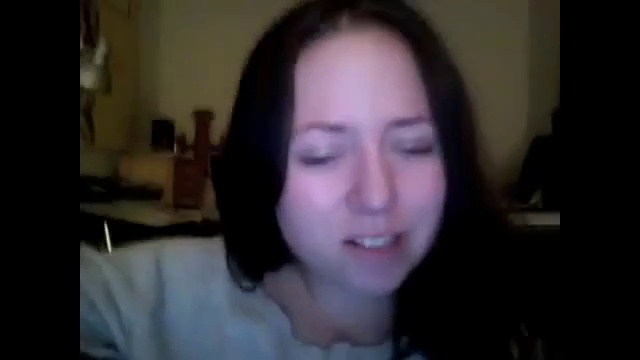

Question:	 What is the emotion in the image c7UH_rxdZv4_0?
Answer:		 sad (Label: 1)
Predicted Answer:	 normal
*********************************************************
*********************************************************


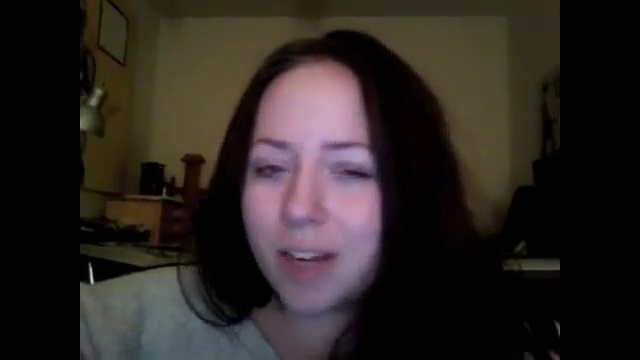

Question:	 What is the emotion in the image c7UH_rxdZv4_10?
Answer:		 happy (Label: 0)
Predicted Answer:	 normal
*********************************************************
*********************************************************


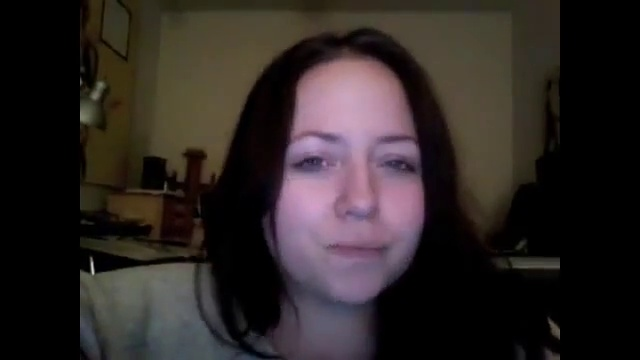

Question:	 What is the emotion in the image c7UH_rxdZv4_11?
Answer:		 sad (Label: 1)
Predicted Answer:	 normal
*********************************************************
*********************************************************


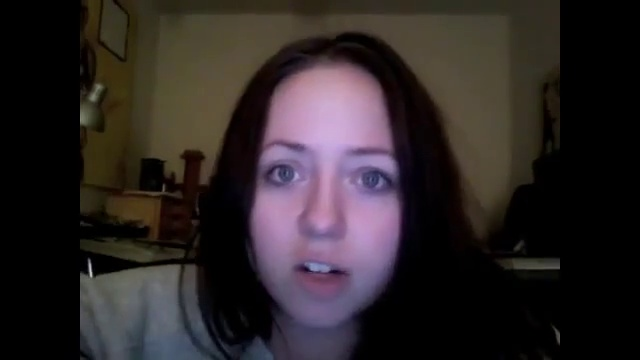

Question:	 What is the emotion in the image c7UH_rxdZv4_12?
Answer:		 sad (Label: 1)
Predicted Answer:	 happy
*********************************************************
*********************************************************


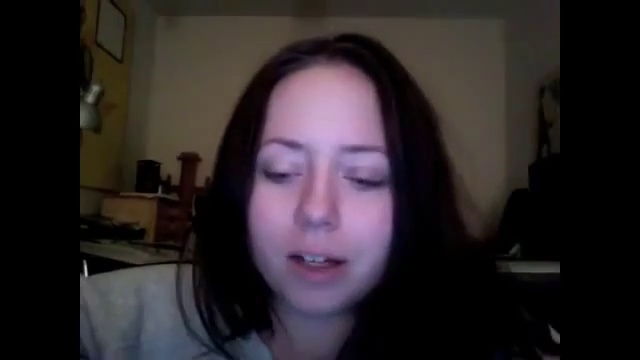

Question:	 What is the emotion in the image c7UH_rxdZv4_13?
Answer:		 happy (Label: 0)
Predicted Answer:	 normal
*********************************************************
*********************************************************


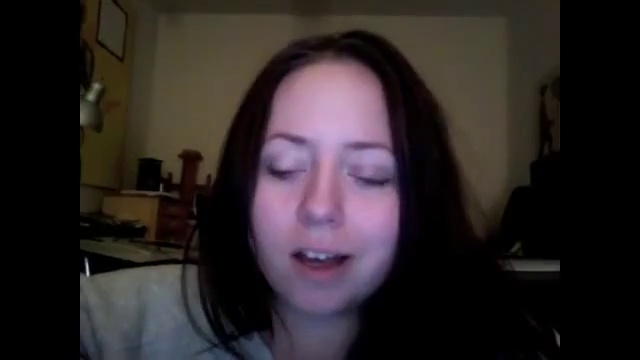

Question:	 What is the emotion in the image c7UH_rxdZv4_14?
Answer:		 sad (Label: 1)
Predicted Answer:	 normal
*********************************************************
*********************************************************


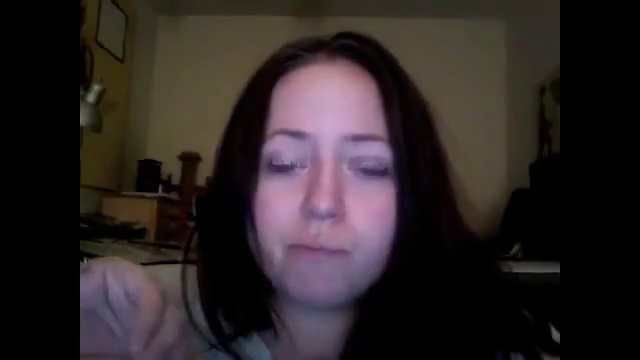

Question:	 What is the emotion in the image c7UH_rxdZv4_15?
Answer:		 sad (Label: 1)
Predicted Answer:	 normal
*********************************************************
*********************************************************


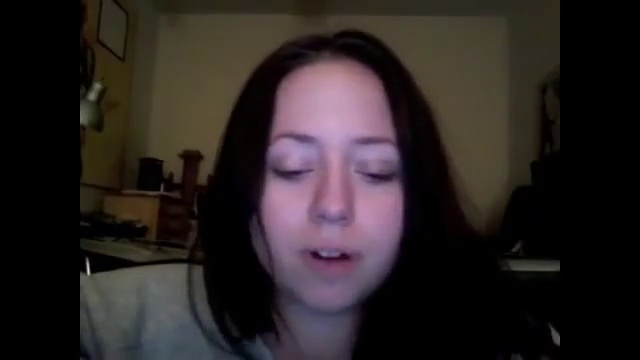

Question:	 What is the emotion in the image c7UH_rxdZv4_16?
Answer:		 sad (Label: 1)
Predicted Answer:	 normal
*********************************************************
*********************************************************


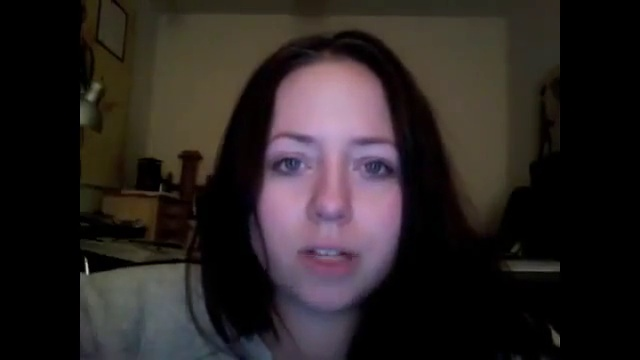

Question:	 What is the emotion in the image c7UH_rxdZv4_17?
Answer:		 sad (Label: 1)
Predicted Answer:	 normal
*********************************************************
*********************************************************


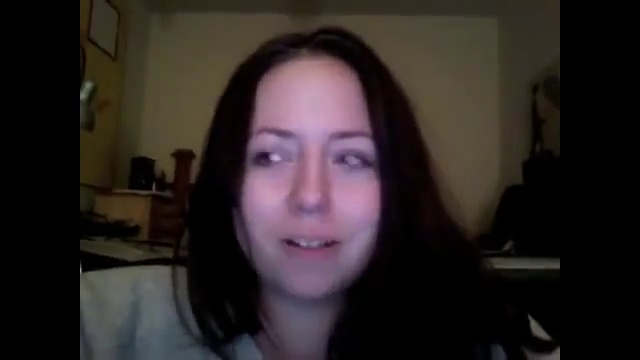

Question:	 What is the emotion in the image c7UH_rxdZv4_18?
Answer:		 sad (Label: 1)
Predicted Answer:	 normal
*********************************************************


In [48]:
for i in range(10):
    print("*********************************************************")
    showExample(train=False, id=i)
    print("Predicted Answer:\t", answer_space[preds[i]])
    print("*********************************************************")

## Inspecting Model Size

In [49]:
def countTrainableParameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of trainable parameters:\t{0:,}".format(num_params))

In [50]:
countTrainableParameters(model) # For BERT-ViT model

No. of trainable parameters:	196,659,971
